# Employee Satisfactory Analysis 


In this notebook, we make use of random forest machine learning algorithms to perform a classification analysis of the 2021 Federal Employee Viewpoint Survey. 
The aim is to determine whether the employee would leave their job using their survey answers and to guide the employer to focus on improvement in certain areas. 

## I. Import Initial Survey Answers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv(r'Datasets/2021_OPM_FEVS_PRDF.csv')


## II. Initial Cleaning/Pre-Processing

Before analyzing data we need to clean and pre-process the data.

### 1. Cleaning the data

During this stage, we drop the NA and duplicate values in our data.

In [3]:
# dropping rows with incomplete information
df = df.dropna()

#dropping all the duplicate values
df.drop_duplicates() 

# still have a large dataset with complete survey answers
len(df)

185696

In [4]:
df.sample(5)

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
114910,145307677120,DL,4.0,4.0,4.0,4.0,4,3,4,4,...,B,B,B,B,B,B,A,B,C,1.765952
188736,101526504569,HS,4.0,2.0,3.0,4.0,2,2,3,5,...,D,B,B,B,A,B,B,B,A,18.890918
250145,141809906131,SZ,4.0,5.0,5.0,5.0,5,4,5,5,...,D,B,B,B,A,B,B,B,A,8.728405
256895,126493516018,SZ,1.0,1.0,1.0,2.0,4,1,1,4,...,B,B,B,A,A,A,B,B,A,1.988507
180736,157634822212,HS,3.0,4.0,4.0,5.0,4,3,3,4,...,A,B,B,B,A,B,A,B,C,9.840876


### 2. Pre-Processing Data

In [5]:
# quantifying "Do not know" (DNK) responses

DNK_answer = dict()
for i in range(2,69):
    DNK_answer[df.columns[i]] = round(len(df[df.iloc[:,i] == "X" ]) * 100 / len(df.iloc[:,i]), 2 )
    
percentage_DNK = pd.DataFrame.from_dict(DNK_answer, orient='index', columns=['percentage'])

# sorting by DNK percentage of answers:
percentage_DNK.sort_values(by='percentage', ascending=False).head(8)

,percentage
Q11,23.93
Q10,16.43
Q12,9.07
Q56,7.79
Q24,6.85
Q38,6.64
Q26,5.39
Q36,5.31


We notice that questions 11, 10 and 12 are the questions with the highest percentages of "Do not know" answers. These are questions that ask for the perception of the performance of coworkers. This suggests that supervisors should use more efective ways of sharing the performance of different units.

Since most of the questions have low ( < 5% ) DNK responses, we replace those values with the mode answer in each question.

In [6]:
for k in range(2,69):
    if 'X' in df.iloc[:,k].values:
        df.iloc[:,k].replace({'X':int(df.iloc[:,k].mode())}, inplace=True)
        
# transforming into numeric data:
df.iloc[:,2:69] = df.iloc[:,2:69].astype(int)

# dropping rows not relevant in EDA:
df = df.drop(["RandomID", "POSTWT"], axis=1)

/tmp/ipykernel_3505/1756257135.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'X' in df.iloc[:,k].values:


In [7]:
## extra data manipulation for the graphs in EDA below:

# including agency_names as column

agency_names = {'AF':'United States Department of the Air Force', 'AG':'Department of Agriculture', 'AM':'U.S. Agency for International Development', 'AR':'United States Department of the Army', 'CM':'Department of Commerce', 'CU':'National Credit Union Administration', 'DD':'OSD, Joint Staff, Defense Agencies, and Field Activities', 'DJ':'Department of Justice', 'DL':'Department of Labor', 'DN':'Department of Energy', 'DR':'Federal Energy Regulatory Commission', 'ED':'Department of Education', 'EE':'Equal Employment Opportunity Commission', 'EP':'Environmental Protection Agency', 'GS':'General Services Administration', 'HE':'Department of Health and Human Services', 'HS':'Department of Homeland Security', 'HU':'Department of Housing and Urban Development', 'IB':'U.S. Agency for Global Media', 'IN':'Department of the Interior', 'NF':'National Science Foundation', 'NQ':'National Archives and Records Administration', 'NU':'Nuclear Regulatory Commission', 'NV':'United States Department of the Navy', 'OM':'Office of Personnel Management', 'SB':'Small Business Administration', 'ST':'Department of State', 'SZ':'Social Security Administration', 'TD':'Department of Transportation', 'TR':'Department of the Treasury', 'XX':'All Other Agencies'}
df['agency_names'] = df.agency.apply(lambda x:agency_names[x])

# external processing of full questions

question_match = {'Q1  - I am given a real opportunity to improve my skills in my organization.': 'Q1', 'Q2  - I feel encouraged to come up with new and better ways of doing things.': 'Q2', 'Q3  - My work gives me a feeling of personal accomplishment.': 'Q3', 'Q4  - I know what is expected of me on the job.': 'Q4', 'Q5  - My workload is reasonable.': 'Q5', 'Q6  - My talents are used well in the workplace.': 'Q6', "Q7  - I know how my work relates to the agency's goals.": 'Q7', 'Q8  - I can disclose a suspected violation of any law, rule or regulation without fear of reprisal.': 'Q8', 'Q9  - The people I work with cooperate to get the job done.': 'Q9', 'Q10 - In my work unit, steps are taken to deal with a poor performer who cannot or will not improve.': 'Q10', 'Q11 - In my work unit poor performers usually:': 'Q11', 'Q12 - In my work unit, differences in performance are recognized in a meaningful way.': 'Q12', 'Q13 - My work unit has the job-relevant knowledge and skills necessary to accomplish organizational goals.': 'Q13', 'Q14 - Employees in my work unit meet the needs of our customers.': 'Q14', 'Q15 - Employees in my work unit contribute positively to my agency’s performance.': 'Q15', 'Q16 - Employees in my work unit produce high-quality work.': 'Q16', 'Q17 - Employees in my work unit adapt to changing priorities.': 'Q17', 'Q18 - Employees in my work unit successfully collaborate.': 'Q18', 'Q19 - Employees in my work unit achieve our goals.': 'Q19', 'Q20 - Employees are recognized for providing high quality products and services.': 'Q20', 'Q21 - Employees are protected from health and safety hazards on the job.': 'Q21', 'Q22 - My agency is successful at accomplishing its mission.': 'Q22', 'Q23 - I recommend my organization as a good place to work.': 'Q23', 'Q24 - I believe the results of this survey will be used to make my agency a better place to work.': 'Q24', 'Q25 - My supervisor supports my need to balance work and other life issues.': 'Q25', 'Q26 - My supervisor is committed to a workforce representative of all segments of society.': 'Q26', 'Q27 - Supervisors in my work unit support employee development.': 'Q27', 'Q28 - My supervisor listens to what I have to say.': 'Q28', 'Q29 - My supervisor treats me with respect.': 'Q29', 'Q30 - I have trust and confidence in my supervisor.': 'Q30', 'Q31 - Overall, how good a job do you feel is being done by your immediate supervisor?': 'Q31', 'Q32 - In my organization, senior leaders generate high levels of motivation and commitment in the workforce.': 'Q32', "Q33 - My organization's senior leaders maintain high standards of honesty and integrity.": 'Q33', 'Q34 - Managers communicate the goals of the organization.': 'Q34', 'Q35 - Managers promote communication among different work units (for example, about projects, goals, needed resources).': 'Q35', 'Q36 - Overall, how good a job do you feel is being done by the manager directly above your immediate supervisor?': 'Q36', "Q37 - I have a high level of respect for my organization's senior leaders.": 'Q37', 'Q38 - Senior leaders demonstrate support for Work-Life programs.': 'Q38', 'Q39 - How satisfied are you with your\xa0involvement in decisions that affect your work?': 'Q39', "Q40 - How satisfied are you with the information you receive from management on what's going on in your organization?": 'Q40', 'Q41 - How satisfied are you with the recognition you receive for doing a good job?': 'Q41', 'Q42 - Considering everything, how satisfied are you with your job?': 'Q42', 'Q43 - Considering everything, how satisfied are you with your pay?': 'Q43', 'Q44 - Considering everything, how satisfied are you with your organization?': 'Q44', 'Q48 - My organization’s senior leaders demonstrate commitment to employee health and safety.': 'Q48', 'Q49 - My organization’s senior leaders support policies and procedures to protect employee health and safety.': 'Q49', 'Q50 - My organization’s senior leaders provide effective communications about what to expect with the return to the physical worksite.': 'Q50', 'Q51 - My supervisor shows concern for my health and safety.': 'Q51', 'Q52 - My supervisor supports my efforts to stay healthy and safe while working.': 'Q52', 'Q53 - My supervisor creates an environment where I can voice my concerns about staying healthy and safe.': 'Q53', "Q55 - My agency's leadership updates employees about return to the worksite planning.": 'Q55', 'Q56 - In plans to return more employees to the worksite, my organization has made employee safety a top priority.': 'Q56', "Q57 - Based on my organization's handling of the COVID-19 pandemic, I believe my organization will respond effectively to future emergencies.": 'Q57'}
full_questions = ['Q1  - I am given a real opportunity to improve my skills in my organization.', 'Q2  - I feel encouraged to come up with new and better ways of doing things.', 'Q3  - My work gives me a feeling of personal accomplishment.', 'Q4  - I know what is expected of me on the job.', 'Q5  - My workload is reasonable.', 'Q6  - My talents are used well in the workplace.', "Q7  - I know how my work relates to the agency's goals.", 'Q8  - I can disclose a suspected violation of any law, rule or regulation without fear of reprisal.', 'Q9  - The people I work with cooperate to get the job done.', 'Q10 - In my work unit, steps are taken to deal with a poor performer who cannot or will not improve.', 'Q11 - In my work unit poor performers usually:', 'Q12 - In my work unit, differences in performance are recognized in a meaningful way.', 'Q13 - My work unit has the job-relevant knowledge and skills necessary to accomplish organizational goals.', 'Q14 - Employees in my work unit meet the needs of our customers.', 'Q15 - Employees in my work unit contribute positively to my agency’s performance.', 'Q16 - Employees in my work unit produce high-quality work.', 'Q17 - Employees in my work unit adapt to changing priorities.', 'Q18 - Employees in my work unit successfully collaborate.', 'Q19 - Employees in my work unit achieve our goals.', 'Q20 - Employees are recognized for providing high quality products and services.', 'Q21 - Employees are protected from health and safety hazards on the job.', 'Q22 - My agency is successful at accomplishing its mission.', 'Q23 - I recommend my organization as a good place to work.', 'Q24 - I believe the results of this survey will be used to make my agency a better place to work.', 'Q25 - My supervisor supports my need to balance work and other life issues.', 'Q26 - My supervisor is committed to a workforce representative of all segments of society.', 'Q27 - Supervisors in my work unit support employee development.', 'Q28 - My supervisor listens to what I have to say.', 'Q29 - My supervisor treats me with respect.', 'Q30 - I have trust and confidence in my supervisor.', 'Q31 - Overall, how good a job do you feel is being done by your immediate supervisor?', 'Q32 - In my organization, senior leaders generate high levels of motivation and commitment in the workforce.', "Q33 - My organization's senior leaders maintain high standards of honesty and integrity.", 'Q34 - Managers communicate the goals of the organization.', 'Q35 - Managers promote communication among different work units (for example, about projects, goals, needed resources).', 'Q36 - Overall, how good a job do you feel is being done by the manager directly above your immediate supervisor?', "Q37 - I have a high level of respect for my organization's senior leaders.", 'Q38 - Senior leaders demonstrate support for Work-Life programs.', 'Q39 - How satisfied are you with your\xa0involvement in decisions that affect your work?', "Q40 - How satisfied are you with the information you receive from management on what's going on in your organization?", 'Q41 - How satisfied are you with the recognition you receive for doing a good job?', 'Q42 - Considering everything, how satisfied are you with your job?', 'Q43 - Considering everything, how satisfied are you with your pay?', 'Q44 - Considering everything, how satisfied are you with your organization?', 'Q48 - My organization’s senior leaders demonstrate commitment to employee health and safety.', 'Q49 - My organization’s senior leaders support policies and procedures to protect employee health and safety.', 'Q50 - My organization’s senior leaders provide effective communications about what to expect with the return to the physical worksite.', 'Q51 - My supervisor shows concern for my health and safety.', 'Q52 - My supervisor supports my efforts to stay healthy and safe while working.', 'Q53 - My supervisor creates an environment where I can voice my concerns about staying healthy and safe.', "Q55 - My agency's leadership updates employees about return to the worksite planning.", 'Q56 - In plans to return more employees to the worksite, my organization has made employee safety a top priority.', "Q57 - Based on my organization's handling of the COVID-19 pandemic, I believe my organization will respond effectively to future emergencies."]

# this is a list of questions we'd like to compare: they have the same kind of response in a likert scale 1 - 5

questions = ['Q1' , 'Q2' , 'Q3' , 'Q4' , 'Q5' , 'Q6' , 'Q7' , 'Q8' , 'Q9' , 'Q10', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q55', 'Q56', 'Q57']

# adding more readable labels to demographic information

df.DDIS.replace({'A':'Yes', 'B':'No'}, inplace=True)
df.DAGEGRP.replace({'A':'Under 40', 'B':'40 or Older'}, inplace=True)
df.DSUPER.replace({'A':'Non-Supervisor/Team Leader', 'B':'Supervisor/Manager/Executive'}, inplace=True)
df.DSEX.replace({'A':'Male', 'B':'Female'}, inplace=True)
df.DMIL.replace({'A':'Military Service', 'B':'No Prior Military Service'}, inplace=True)
df.DLEAVING.replace({'A':'No', 'B':'Yes', 'C':'Yes', 'D':'Yes'}, inplace=True)

demographic_match = { 'Individuals with disability':'DDIS', 'Age group':'DAGEGRP', 'Supervisor status':'DSUPER', 'Sex':'DSEX', 'Military status':'DMIL', 'Planning to leave within next year':'DLEAVING' }


## III. Exploratory Data Analysis

### 1. Correlation Analysis

Likert-type survey scores are inherently non-numeric, and applying techniques designed for numeric data on Likert-type data
will yield answers that can be difficult to interpret. When it comes to correlation analysis for instance, the default choice is the Pearson correlation measure. However, Kendall correlations are better suited for ranked data.

Below we compare Pearson and Kendall correlations matricies to judge if algorithims using Pearson will be meaningful for our Likert data.

We find that they are almost indistinguishable which gives confidence to using numeric techniques with embeded Pearson correlations.

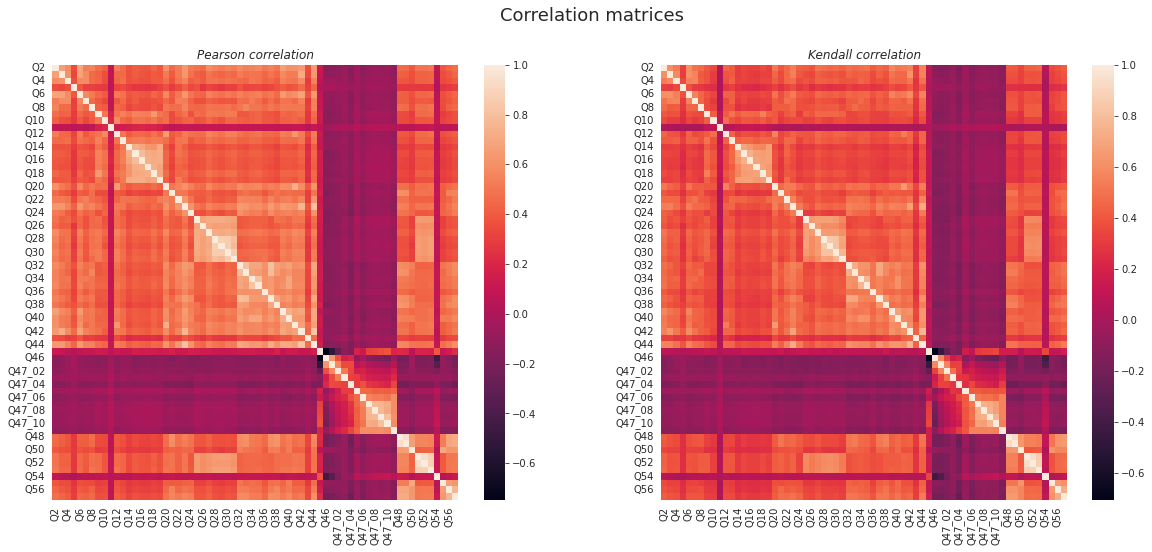

In [21]:
pearson_corr = df.iloc[:, 2:69].corr()
kendall_corr = df.iloc[:, 2:69].corr(method='kendall')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8) )

sns.heatmap(pearson_corr, ax=ax1)
ax1.set_title('Pearson correlation', fontstyle='italic')

sns.heatmap(kendall_corr, ax=ax2)  ## it may take a few seconds to run
ax2.set_title('Kendall correlation', fontstyle='italic')

plt.suptitle("Correlation matrices", fontsize=18)
plt.show()

A remark is in order concerning the negative correlation cross that takes place around questions Q47_01 through Q47_10. This part of the survey is intended to measure the different organizations' responses to the covid-19 pandemic. For this block, answers are coded from 1 to 3, and 1 can be interpreted as a __positive__ response to the specific question, while 3 as __negative__, which goes in the opposite direction of the rest of the questions in the survey.

Some literature has suggested the use of polychoric correlations as an even better way to measure correlations for likert-type survey data. We computed this kind of correlation with the `RyStats` python module and the result was essentially the same.

### 2. Demographic and Agency specific Analysis

In [25]:
@interact_manual

def box_plot_comparison(select = list(demographic_match.keys())):
    
    '''
    this function creates a side by side graph of box plots of all the questions with likert type
    response, filtered by a chosen demographic (this is the parameter)
    '''
    
    category = demographic_match[select]
    
    df_melt = df.melt(id_vars = category,
                  value_vars = questions,
                  var_name = 'columns')

    plt.figure(figsize=(30,6))
    box_plots = sns.boxplot(data = df_melt, x = 'columns', y = 'value', 
                            hue = category, order = questions, palette = np.random.choice(['tab10','Accent','Set1']))
    
    plt.title(f'Box plots of survey answers for each question by the demographic "{select}"', fontsize=18)
    plt.xlabel("Survey questions", fontsize=13)
    plt.ylabel("1 = strongly disagree / very dissatisfied --- 5 = strongly agree / very satisfied")
    plt.legend(bbox_to_anchor=(0.9, 1.3), borderaxespad=0, prop={'size': 15})

interactive(children=(Dropdown(description='select', options=('Individuals with disability', 'Age group', 'Sup…

We can interact with the previous cell and get box plots of the survey answers among different demographics. For example, here is the collection of boxplots discriminated by sex:

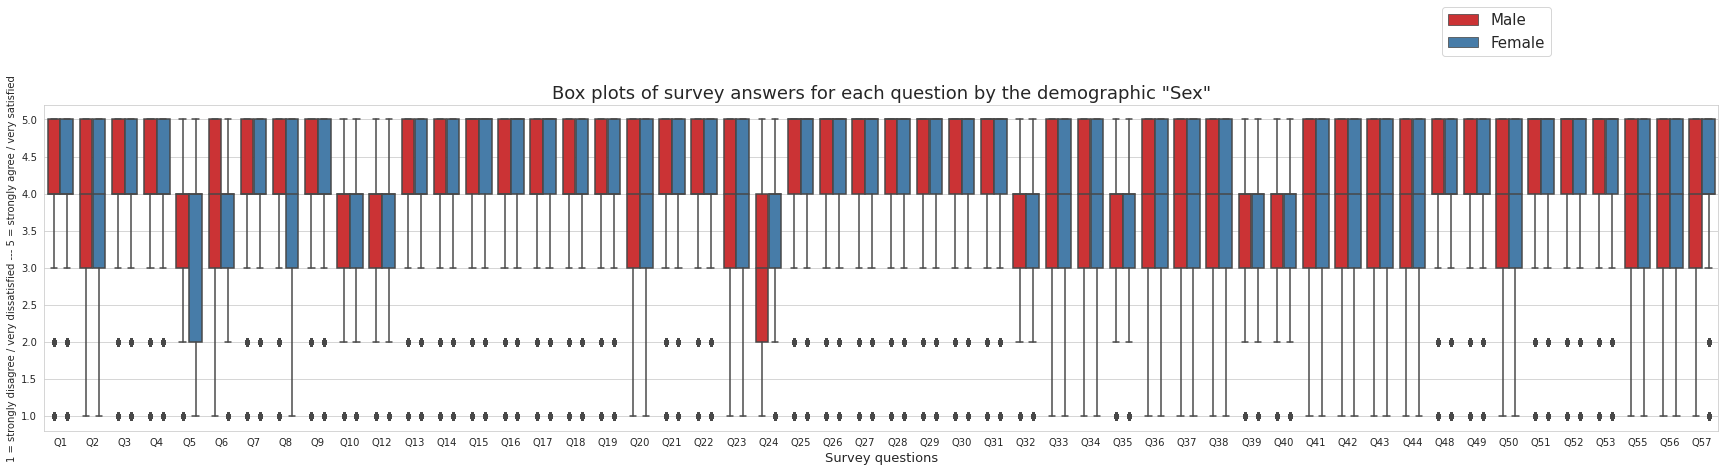

In [26]:
box_plot_comparison('Sex')

We notice that they follow very similar distributions for almost all of the survey questions. Among the few exceptions, for example, there is a wider range in one sex for questions 5 and 24. 

- Question 5 posits 'My workload is reasonable'. In average, based on the responses of this survey, women disagree more than men that their workload is reasonable.

- Question 24 posits 'I believe the results of this survey will be used to make my agency a better place to work.' We see then that men are less confident than women that the results of the survey will make their agency a better place to work.

On the other hand, the demographic asking employees' whether they are considering leaving their organization within the next year shows more variation:

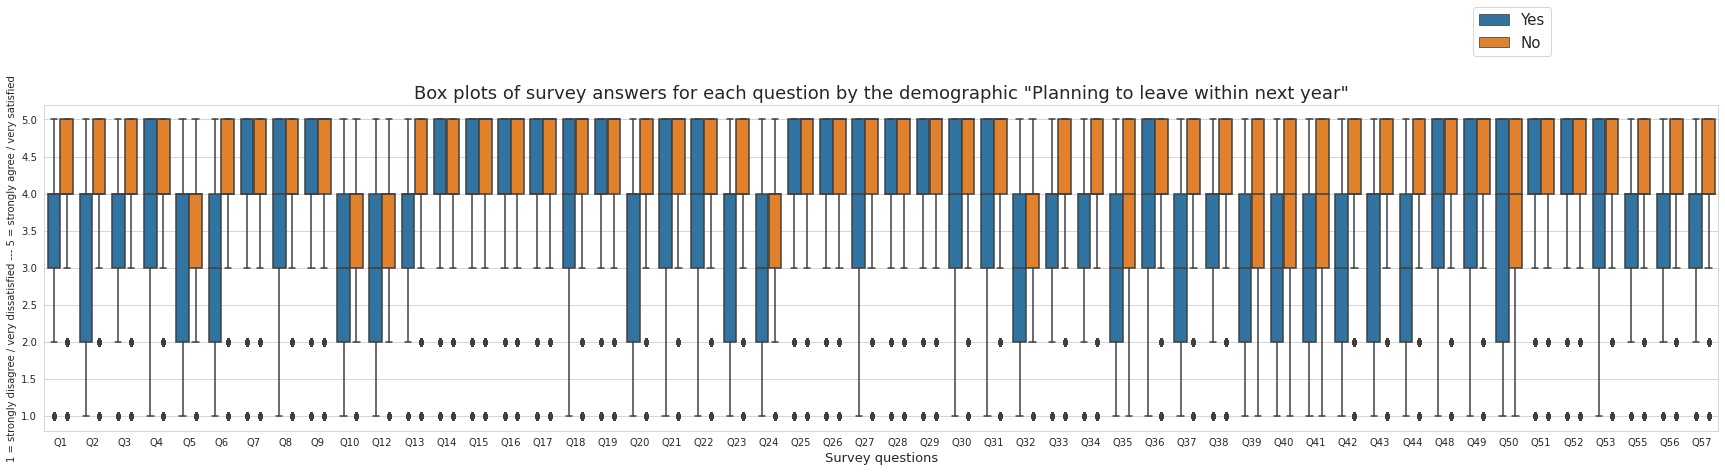

In [27]:
box_plot_comparison('Planning to leave within next year')

This variation in the responses --between the people planning to leave and the ones that are not-- leads us to suspect it might be possible to classify people in this demographic based on their answers to the other questions of the survey. This is going to be our goal in Part IV of this project, where we will use **random forests** to create a **classifier**.

Another important piece of information of dataset is the specific organization (or agency) within the Federal Government where each of the respondents works. In order to visualize and compare different agencies, we create stacked bar plots for all of the questions and sort them by positive responses to them.

In [46]:
@interact_manual

def agency_comparison_by_question(select = full_questions): 
    
    '''
    this function takes a parameter one of the questions of the survey and creates 
    a 100% stacked bar plot (from a frequency table) for each of the agencies for the chosen question, and then
    sorts the agencies from largest to smallest positive responses
    '''
    
    selected_question = question_match[select]
    
    cross = 100 * pd.crosstab(index = df['agency_names'],
                             columns = df[selected_question],
                             normalize = "index")
    
    cross_sor = cross.sort_values(by=5, ascending = False)

    cross_sor.plot(kind = 'barh',
                   stacked = True,
                   colormap = np.random.choice(['tab10','Accent','Set1']),
                   figsize = (14, 8))
    
    plt.title(select, fontsize=15)
    plt.xlabel("Percentage of answers for each response: 1 = strongly disagree / very dissatisfied --- 5 = strongly agree / very satisfied")
    plt.ylabel("Agency names (sorted by agreeance / satisfaction)")

interactive(children=(Dropdown(description='select', options=('Q1  - I am given a real opportunity to improve …

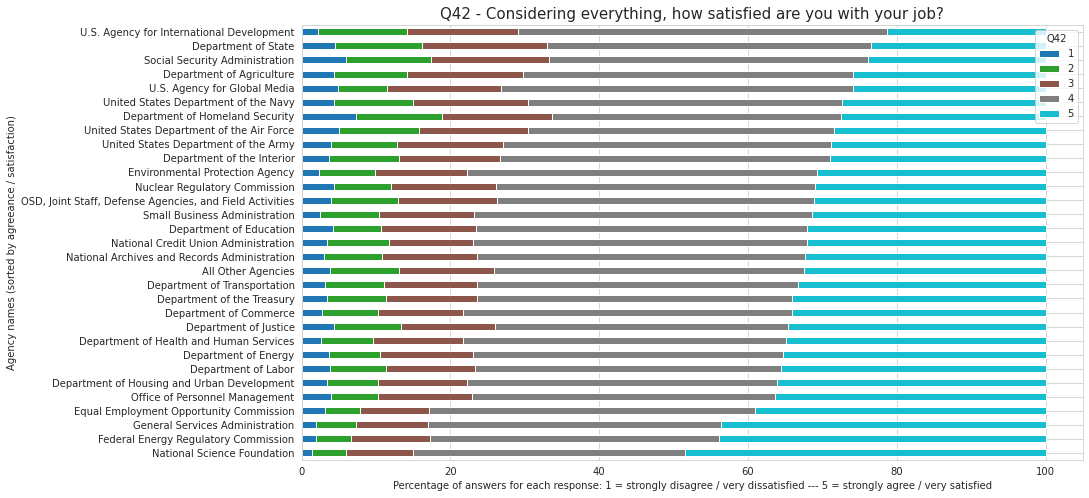

In [49]:
agency_comparison_by_question(select='Q42 - Considering everything, how satisfied are you with your job?')

For instance, when we compare the employees' satisfaction level (which corresponds to Question 42) among all the different agencies, the greatest satisfaction levels reported come from the National Science Foundation and the Federal Energy Regulatory Foundation, while the lowest levels are from the International Development agency and the Department of State.

Despite this difference for particular agencies, we see that in general there is a high reported level of satisfaction from all employees in the survey: combining positive responses (5 = very satisfied and 4 = satisfied) gives us nearly 70% of people in each of the agencies reporting satisfaction with their jobs. Here we may bring into mind the fact that Federal Employees enjoy many benefits, such as health insurance, retirement plans, and more, which are not universally shared by people working non-federal jobs.

It is worth noting at this point that the agencies in the survey have different sizes. Here is the percentage share of some of them (sorted from biggest to smallest):

In [45]:
with pd.option_context('display.max_rows',10):
    print(df['agency_names'].value_counts() * 100 / len(df))

United States Department of the Army       12.782720
Department of Homeland Security             8.837562
United States Department of the Navy        7.320567
Department of Agriculture                   7.282871
Department of Health and Human Services     6.863368
                                             ...    
Office of Personnel Management              0.329032
National Science Foundation                 0.259026
National Credit Union Administration        0.233715
Equal Employment Opportunity Commission     0.205174
U.S. Agency for Global Media                0.186865
Name: agency_names, Length: 31, dtype: float64


Based on our last bar plot, we visually noticed that different agencies have different distributions regarding their reported satisfaction level with their jobs. We now want to make this comparison more explicit for any two agencies across all the questions on the survey. Since it is hard to visualize bar plots for all the questions in the survey at once, we use heatmaps and test whether the answers to any given questions are statistically different for the two agencies chosen.

In [54]:
import scipy

@interact_manual

def survey_comparison_by_agency(select1 = list(df['agency_names'].unique()), 
                     select2 = list(df['agency_names'].unique())):
    
    '''
    this function takes any two agencies as parameter and proceeds to:
    
    * create a heat map of the percentages of the answers of each of the questions with likert-type scales for each of the chosen agencies
    * perform a hypothesis test for each of the questions with the Mann Whitney procedure, comparing the median answers in each of the questions    
    '''
    
    agency1 = df[df.agency_names.isin({select1})]
    agency2 = df[df.agency_names.isin({select2})]
    
    length_agency1, length_agency2 = len(agency1), len(agency2)
    
    answer_perc_agency1 = pd.DataFrame(index=[5,4,3,2,1])
    answer_perc_agency2 = pd.DataFrame(index=[5,4,3,2,1])
    significance = pd.DataFrame()
    
    for quest in questions:
        
        answer_perc_agency1[quest] = pd.DataFrame(agency1[quest].value_counts() * 100 / length_agency1)
        answer_perc_agency2[quest] = pd.DataFrame(agency2[quest].value_counts() * 100 / length_agency2)
        
        _, pvalue = scipy.stats.mannwhitneyu(agency1[quest], agency2[quest])
        significance[quest] = pd.DataFrame({quest:(pvalue>.05)}, index=['significant'])

    color = np.random.choice(['Greens', 'Blues', 'Purples', 'Oranges'])
    norm = plt.Normalize(0,100)
    prob = plt.Normalize(0,0.1)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,8), gridspec_kw={'height_ratios': [5, 5, 1]})
    sns.heatmap(answer_perc_agency1, cmap=color, ax=ax1, norm=norm, cbar_kws={'label': 'Percentage'})
    sns.heatmap(answer_perc_agency2, cmap=color, ax=ax2, norm=norm, cbar_kws={'label': 'Percentage'})
    sns.heatmap(significance, cmap='Reds_r', ax=ax3, norm=prob, cbar_kws={'label': 'p-value'})
    plt.suptitle(f'Percentage of survey answers for {select1} (top) vs. {select2} (bottom). \n Significance of different medians with Mann-Whitney test at 5% level (p-value).', fontsize=15)
    fig.tight_layout(pad=1.0)
    plt.show()

interactive(children=(Dropdown(description='select1', options=('All Other Agencies', 'United States Department…

Let us compare the two top agencies regarding reported satisfaction level previously computed, namely, the National Science Foundation and the Energy Regulatory Commission.

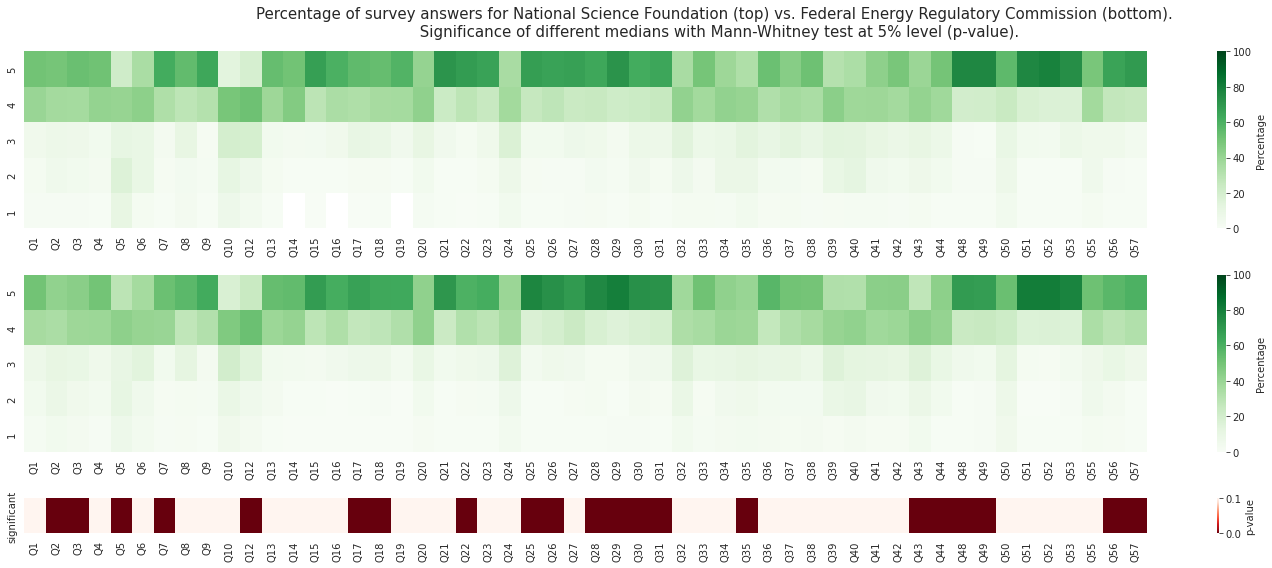

In [52]:
survey_comparison_by_agency('National Science Foundation', 'Federal Energy Regulatory Commission')

As before, we notice left skewed distribution among all the questions for these two agencies. We point out that the difference in job satisfaction is not statistically significant, but that there is evidence of difference in Q43 and Q44, for instance, which are questions regarding their satisfaction levels with their pay and their organization, respectively.

### 3. PCA and Factor Analysis

## IV. Classification with Random Forest

### 1. Pre-Processing for Random Forest

In this section, we want to transfer all the categorical data into numerical ones.

In [55]:
X = pd.get_dummies(df.drop(['agency','DLEAVING'],axis=1),drop_first=True)
y = df["DLEAVING"].copy()
y.replace({'No':0, 'Yes':1}, inplace=True)

### 2. Hyper-Parameter Training

In [58]:
from sklearn.ensemble import RandomForestClassifier

First, we tune the hyper parameter for our random forests using results from our factor analysis.

In [59]:
from Data_Analysis.Tune import RFtune

In [60]:
bestF, X_test, y_test = RFtune(depth = range(1,24), split=[2,4], 
                               leaf = range(1,3), estimators=[50,100], df = X, y = y)


Fitting 3 folds for each of 184 candidates, totalling 552 fits


KeyboardInterrupt: 

In [26]:
# print best parameter after tuning
print(bestF.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(bestF.best_estimator_)


{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=15, max_features=9, min_samples_leaf=2,
                       random_state=20)


### 3. Model Result


In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, f1_score 

Using the parameters trained in the previous section, we get the following prediction.

In [28]:
grid_predictions = bestF.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))
print("Accuracy:",accuracy_score(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     12655
           1       0.68      0.45      0.54      5915

    accuracy                           0.76     18570
   macro avg       0.73      0.68      0.69     18570
weighted avg       0.75      0.76      0.74     18570

Accuracy: 0.7587506731287023


In [29]:
f1_score(y_test, grid_predictions, average='weighted')

0.7431701140383296

Note that we get a f1 score of roughly 0.73. We may compare with the case where we make predictions using mode only. In which case we get the following score: 

In [30]:
f1_score(y_test, np.ones((len(X_test), 1)))

0.48315295078619563

Easy to see we get a increment from .48 to .73 which is a great improvement.

/opt/homebrew/Caskroom/miniforge/base/envs/bootcamp_Bing/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


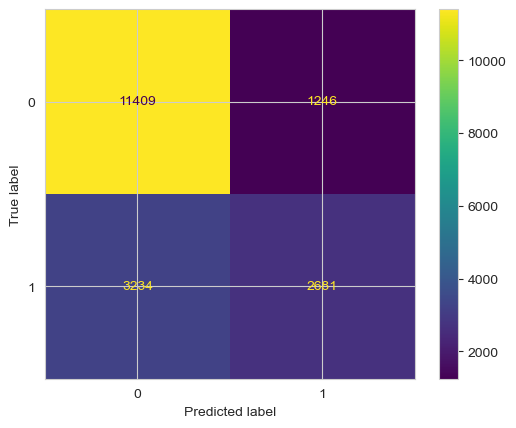

In [31]:
plot_confusion_matrix(bestF,X_test,y_test)

In [32]:
score_df = pd.DataFrame({'feature':[cols for cols in X_test.columns 
                                    if (bestF.best_estimator_.feature_importances_[X_test.columns.get_loc(cols)] > 0.01)],
                            'importance_score': [fimp for fimp in bestF.best_estimator_.feature_importances_ if (fimp > 0.01)]})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
22,Q42,0.106680
24,Q44,0.076341
6,Q23,0.072648
4,Q6,0.042067
2,Q3,0.038072
21,Q41,0.024855
20,Q40,0.023398
23,Q43,0.021374
13,Q32,0.021133
7,Q24,0.019893


## V. Conclusions
